Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

Read data

In [3]:
df_train = pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
df_test = pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

In [4]:
df_train.head(7) # check data (first 7 rows)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive


In [5]:
df_test.head(7) # check data (first 7 rows)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive


In [6]:
df_train.shape # check data

(41157, 6)

In [7]:
df_test.shape # check data

(3798, 6)

Visualize data

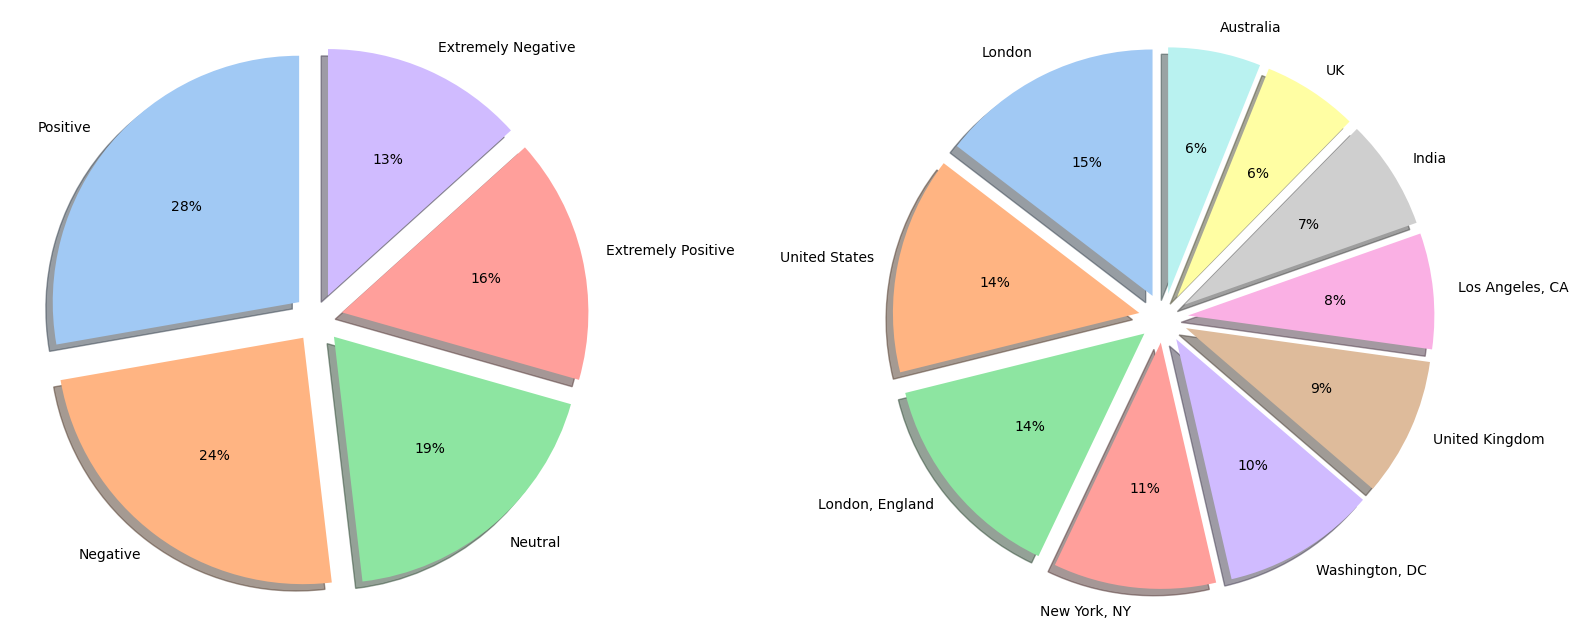

In [8]:
def plot_pie(df, column, axes, amount=-1):
    """ PIE PLOT """
    count_classes = df[column].value_counts()
    if (amount != -1):
        count_classes = count_classes[:amount]
    n_classes = len(count_classes)
    explode = (0.1,) * n_classes # explode for 0.1 each slice
    colors = sns.color_palette('pastel') # pastel colors
    axes.pie(count_classes, 
             labels=count_classes.index, 
             explode=explode,
             colors=colors,
             autopct='%.0f%%',
             shadow=True, 
             startangle=90)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
plot_pie(df_train, "Sentiment", axes[0])
plot_pie(df_train, "Location", axes[1], 10) # only first 10 locations
plt.show()

In [9]:
def plot_stats(df, column, ax, color, angle):
    """ PLOT STATS OF DIFFERENT COLUMNS """
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

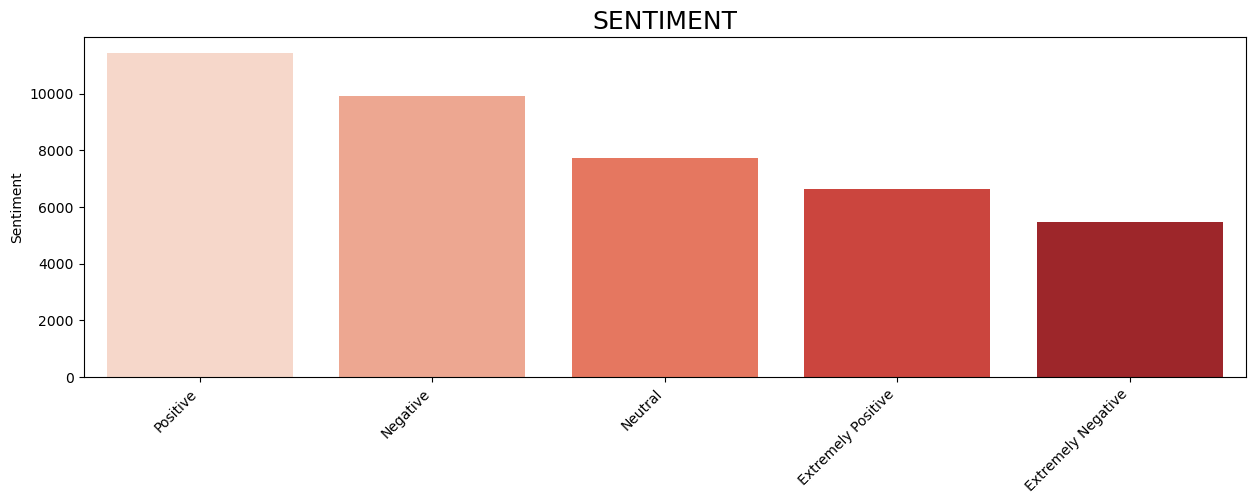

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(df_train, "Sentiment", axes, "Reds", 45)
plt.show()

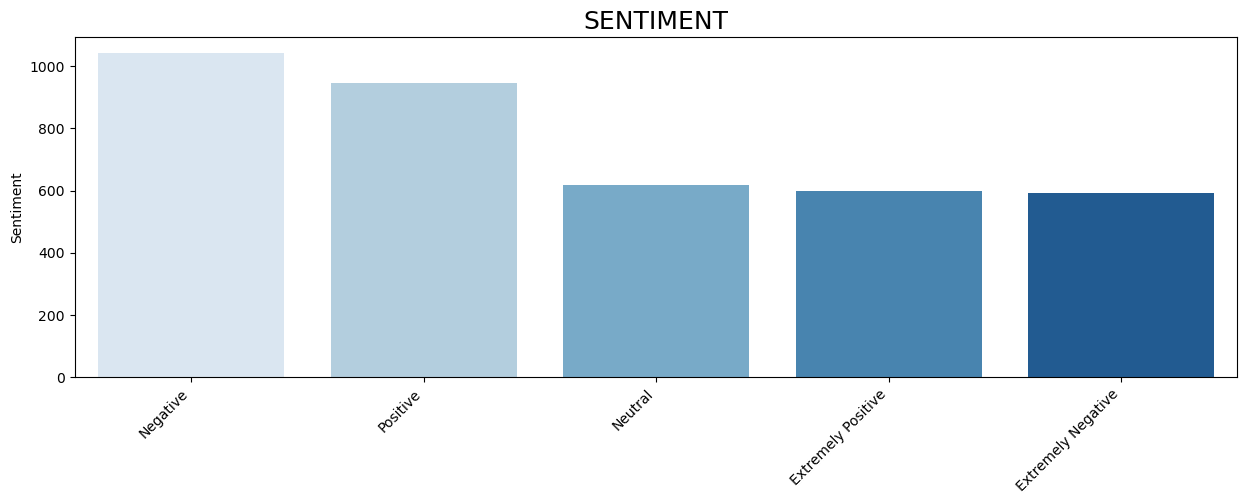

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(df_test, "Sentiment", axes, "Blues", 45)
plt.show()

In [12]:
def number_of_characters(df, label, ax, color):
    """ COUNT NUMBER OF CHARACTERS """
    tweet_len = df[df['Sentiment']==label]['OriginalTweet'].str.len()
    ax.hist(tweet_len, color=color)
    ax.set_title(label.upper(), fontsize=18)

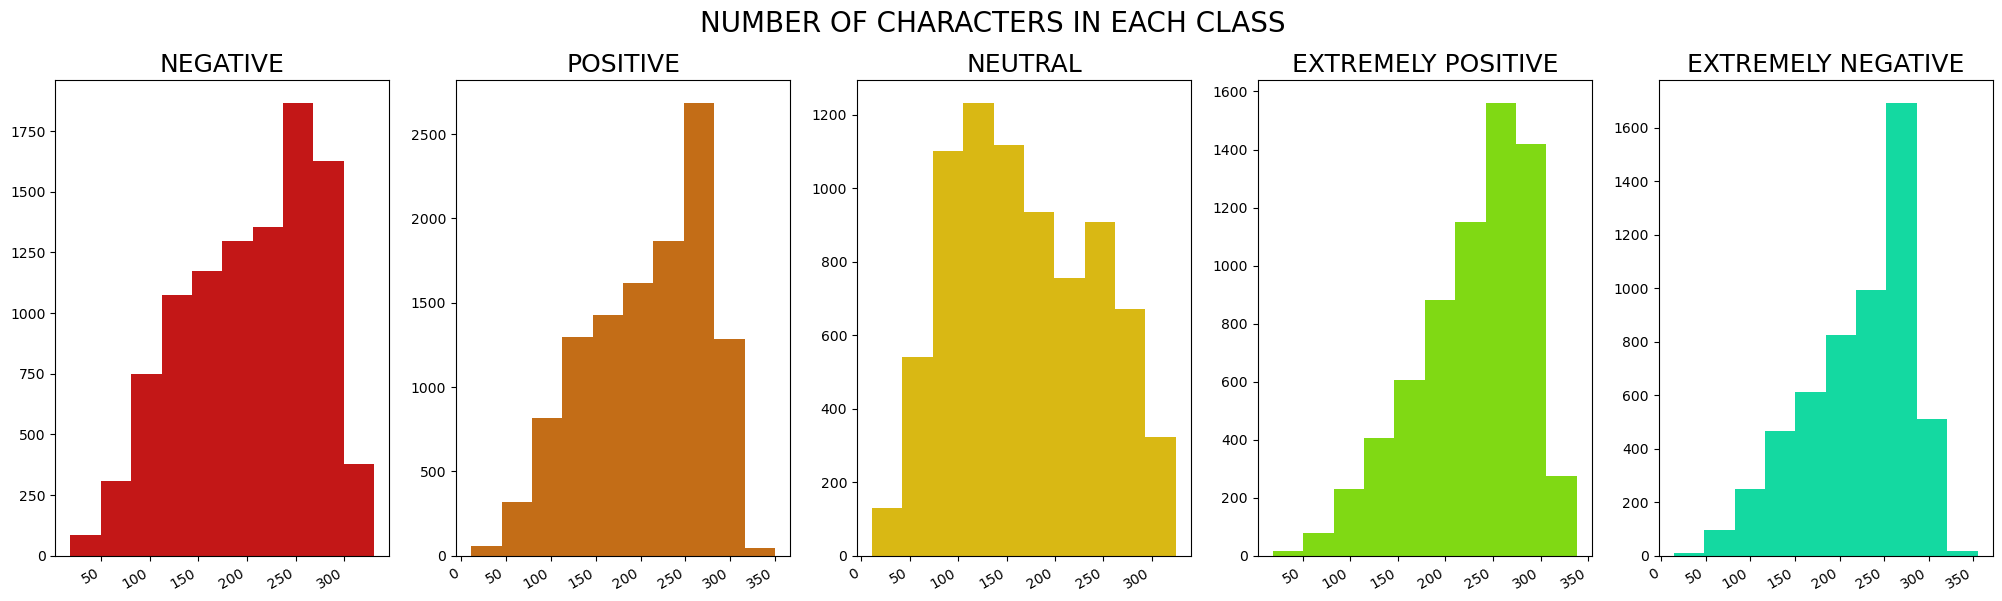

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,7))
fig.autofmt_xdate()
fig.suptitle('NUMBER OF CHARACTERS IN EACH CLASS', fontsize=20)
number_of_characters(df_train, "Negative", axes[0], '#c31717')
number_of_characters(df_train, "Positive", axes[1], '#c36d17')
number_of_characters(df_train, "Neutral", axes[2], '#d9b814')
number_of_characters(df_train, "Extremely Positive", axes[3], '#80d914')
number_of_characters(df_train, "Extremely Negative", axes[4], '#14d9a1')
plt.show()

In [14]:
def number_of_words(df, label, ax, color):
    """ COUNT NUMBER OF WORDS """
    tweet_len = df[df['Sentiment']==label]['OriginalTweet'].str.split().map(lambda x: len(x))
    ax.hist(tweet_len, color=color)
    ax.set_title(label.upper(), fontsize=18)

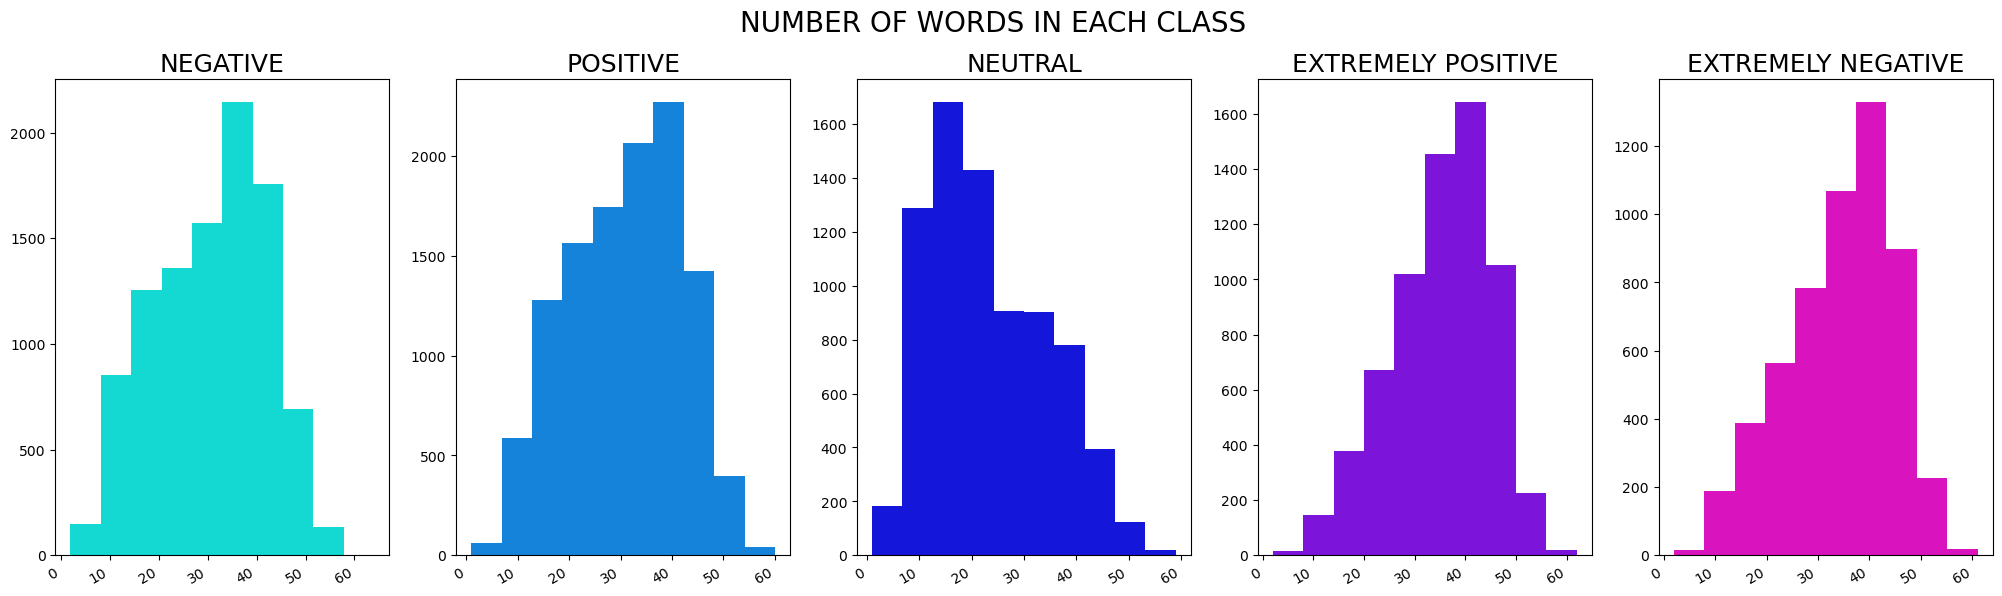

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,7))
fig.autofmt_xdate()
fig.suptitle('NUMBER OF WORDS IN EACH CLASS', fontsize=20)
number_of_words(df_train, "Negative", axes[0], '#14d9d2')
number_of_words(df_train, "Positive", axes[1], '#1483d9')
number_of_words(df_train, "Neutral", axes[2], '#1417d9')
number_of_words(df_train, "Extremely Positive", axes[3], '#7d14d9')
number_of_words(df_train, "Extremely Negative", axes[4], '#d914be')
plt.show()

In [16]:
def avg_word_length(df, label, ax, color):
    """ THE AVERAGE WORD LENGTH """
    word = df[df['Sentiment']==label]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x: np.mean(x)), ax=ax, color=color)

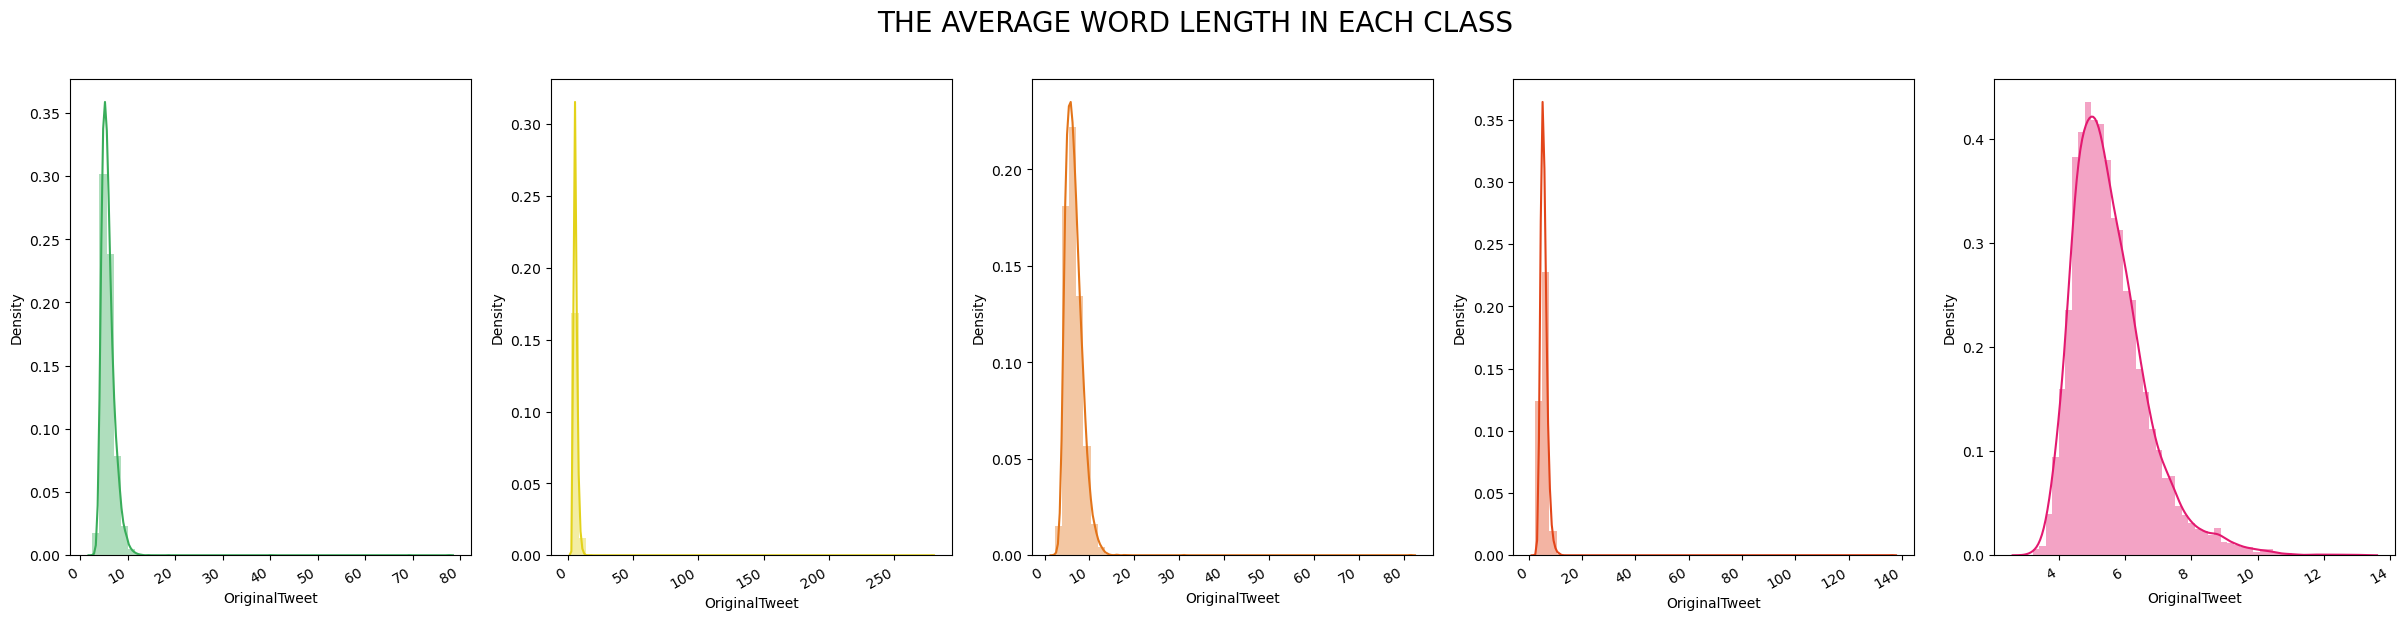

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,7))
fig.autofmt_xdate()
fig.suptitle('THE AVERAGE WORD LENGTH IN EACH CLASS', fontsize=20)
avg_word_length(df_train, "Negative", axes[0], '#39ad5a')
avg_word_length(df_train, "Positive", axes[1], '#e3d219')
avg_word_length(df_train, "Neutral", axes[2], '#e37419')
avg_word_length(df_train, "Extremely Positive", axes[3], '#e34519')
avg_word_length(df_train, "Extremely Negative", axes[4], '#e31970')
plt.show()

Prepare data

In [18]:
y = df_train["Sentiment"].map({"Negative":0,
                               "Positive": 1,
                               "Neutral": 2,
                               "Extremely Positive": 3,
                               "Extremely Negative": 4
                               })

y_test = df_test["Sentiment"].map({"Negative":0,
                                   "Positive": 1,
                                   "Neutral": 2,
                                   "Extremely Positive": 3,
                                   "Extremely Negative": 4
                                                })

In [19]:
# get the number of classes
n_classes = df_train["Sentiment"].nunique()
n_classes

5

TextVectorization

In [20]:
# extract text data from dataframe 
X = df_train['OriginalTweet'].to_numpy()
X_test = df_test['OriginalTweet'].to_numpy()

In [21]:
# TextVectorization transforms a batch of strings into either a list of token indices or a dense representation
text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize="lower_and_strip_punctuation", 
                                    output_sequence_length=15)

In [22]:
# adapt dataset
text_vectorizer.adapt(X)

In [23]:
# example
text_vectorizer(["Computer vision and deep learning"])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[4030, 8323,    4, 1658, 2066,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

Embedding

In [24]:
# turns positive integers (indexes) into dense vectors of fixed size
embedding = Embedding(input_dim=10000, output_dim=128, input_length=15, name = 'embeding_1')
embedding

In [25]:
# example
sample_embed = embedding(text_vectorizer(["Computer vision and deep learning"]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02043455, -0.00160827, -0.03138856, ..., -0.02630102,
          0.03816322,  0.04799509],
        [ 0.0054311 ,  0.02891773, -0.01820574, ...,  0.02228195,
          0.0078299 , -0.00505118],
        [ 0.03401167,  0.01030234, -0.01308239, ...,  0.03740838,
          0.01840712, -0.01070317],
        ...,
        [ 0.01902157,  0.0113531 , -0.02074951, ..., -0.00824047,
          0.03710378,  0.00102202],
        [ 0.01902157,  0.0113531 , -0.02074951, ..., -0.00824047,
          0.03710378,  0.00102202],
        [ 0.01902157,  0.0113531 , -0.02074951, ..., -0.00824047,
          0.03710378,  0.00102202]]], dtype=float32)>

Train our models

In [26]:
def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [27]:
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)
    
    axes[0].plot(model_history.history['accuracy'], label='train accuracy', color='g', axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'], label='val accuracy', color='r', axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16) 
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'], label='train loss', color='g', axes=axes[1])
    axes[1].plot(model_history.history['val_loss'], label='val loss', color='r', axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16) 
    axes[1].legend(loc='upper left')

    plt.show()

In [28]:
def run_model(inputs, outputs, name, epochs, NN_name, suptitle):
    """ GENERAL FUNCTION FOR RUNNING NEURAL NETWORK MODELS"""
    
    # create model
    model = tf.keras.Model(inputs, outputs, name=name)
    # compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=["accuracy"])
    # check model
    model.summary()
    print()
    # train model
    print("...training model...")
    model_history = model.fit(X, 
                              y, 
                              epochs=epochs, 
                              validation_data=(X_test, y_test),
                              verbose=True)
    print()
    # check on test data
    print("...evaluating model...")
    model.evaluate(X_test, y_test)
    print()
    
    # check shape
    print("y_test.shape = ", y_test.shape)
    print()
    
    # get the probabilities
    y_prob = model.predict(X_test)
    # get the classes
    y_hat = y_prob.argmax(axis=-1) 
    # see the test labels
    print("y_test =\n", y_test)
    print()
    # check results
    res = calculate_results(y_test, y_hat)
    res = pd.DataFrame([res])
    res.insert(0, "model", NN_name)
    # visualize NN history
    plot_NN_history(model_history, suptitle)
    return model, res

## LSTM
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).

In [29]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 1,329,733
Trainable params: 1,329,733
Non-trainable params: 0
______________________________________________

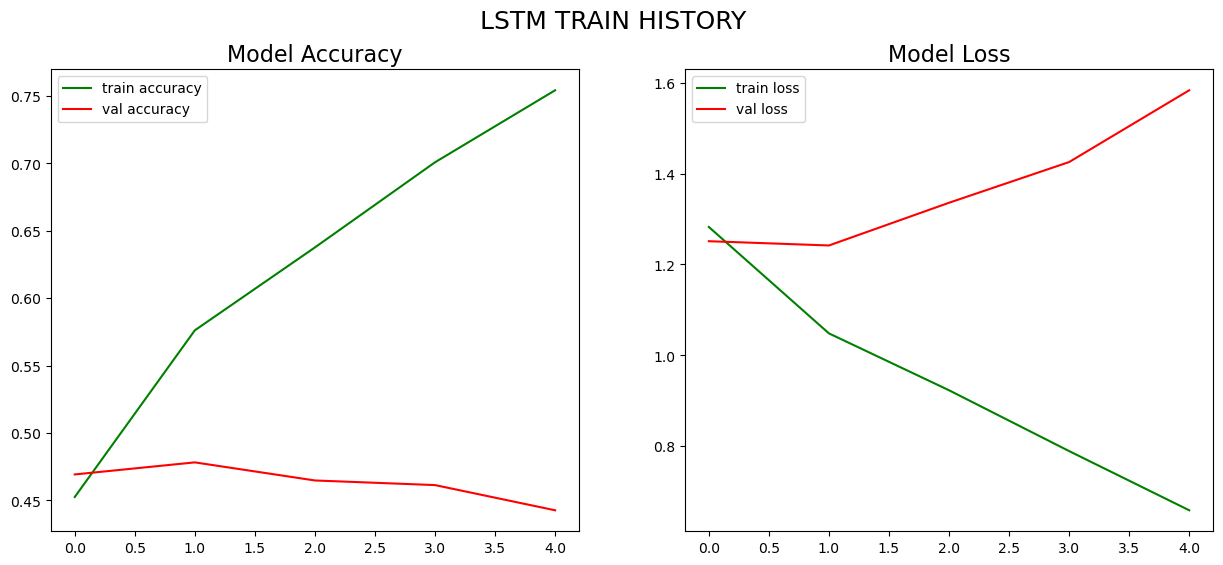

,model,accuracy,precision,recall,f1
0,LSTM,44.260137,0.445515,0.442601,0.442901


In [30]:
# run our model
model, res = run_model(inputs, outputs, "model_LSTM", 5, "LSTM", "LSTM TRAIN HISTORY")
res # print the accuracy metrics results

## GRU
Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate. GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM. GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets.

In [31]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_1_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,317,573
Trainable params: 1,317,573
Non-trainable params: 0
_____________________________________________

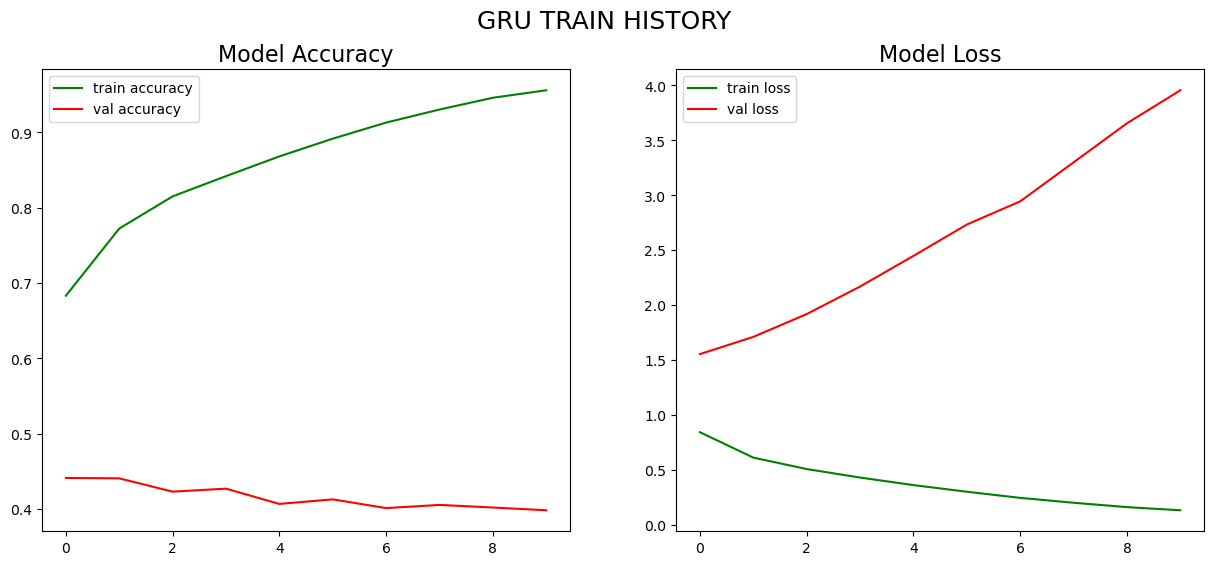

,model,accuracy,precision,recall,f1
0,GRU,39.836756,0.399095,0.398368,0.398322


In [32]:
model_1, res1 = run_model(inputs, outputs, "model_1_GRU", 10, "GRU", "GRU TRAIN HISTORY")
res1

## Bidirectional LSTM
In bidirectional LSTM, instead of training a single model, we introduce two. The first model learns the sequence of the input provided, and the second model learns the reverse of that sequence.

In [33]:
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_2_Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,379,461
Trainable params

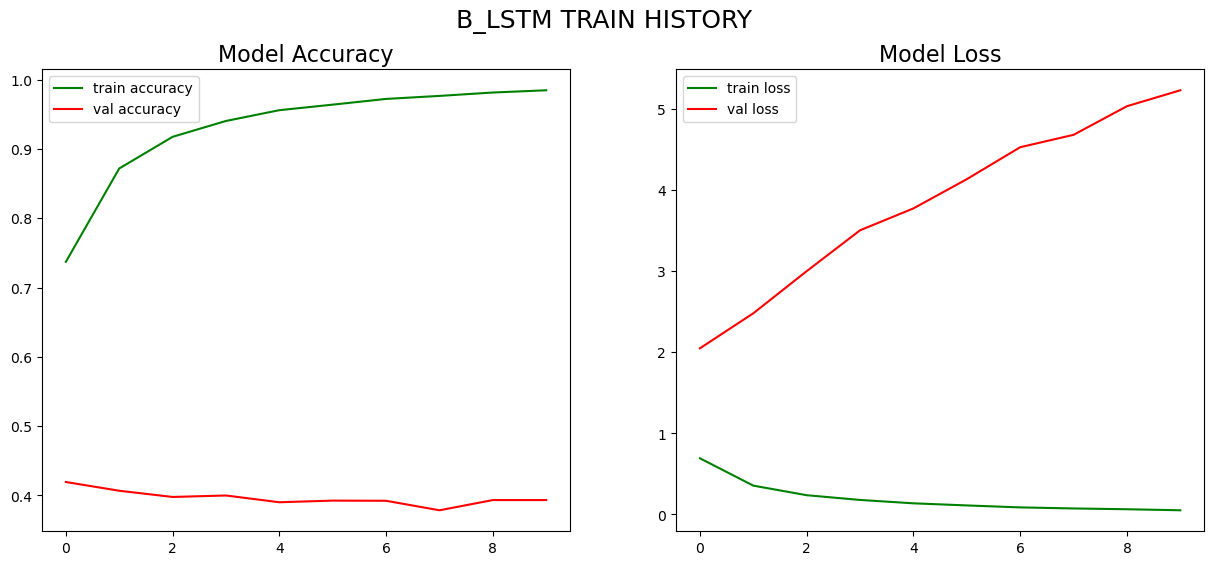

,model,accuracy,precision,recall,f1
0,B_LSTM,39.336493,0.393053,0.393365,0.39274


In [34]:
model_2, res2 = run_model(inputs, outputs, "model_2_Bidirectional_LSTM", 10, "B_LSTM", "B_LSTM TRAIN HISTORY")
res2

## Bidirectional GRU
Bidirectional wrapper for GRU.

In [35]:
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_3_Bidirectional_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,355,141
Trainable params:

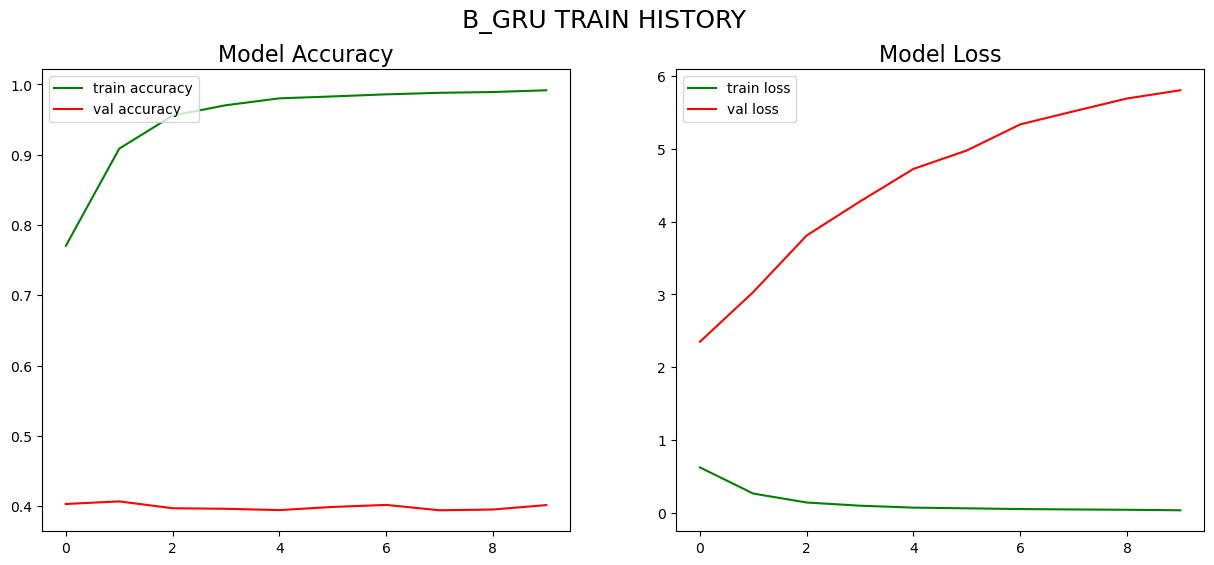

,model,accuracy,precision,recall,f1
0,B_GRU,40.152712,0.401179,0.401527,0.401074


In [36]:
model_3, res3 = run_model(inputs, outputs, "model_3_Bidirectional_GRU", 10, "B_GRU", "B_GRU TRAIN HISTORY")
res3

Convolutional NN

In [37]:
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 5)              

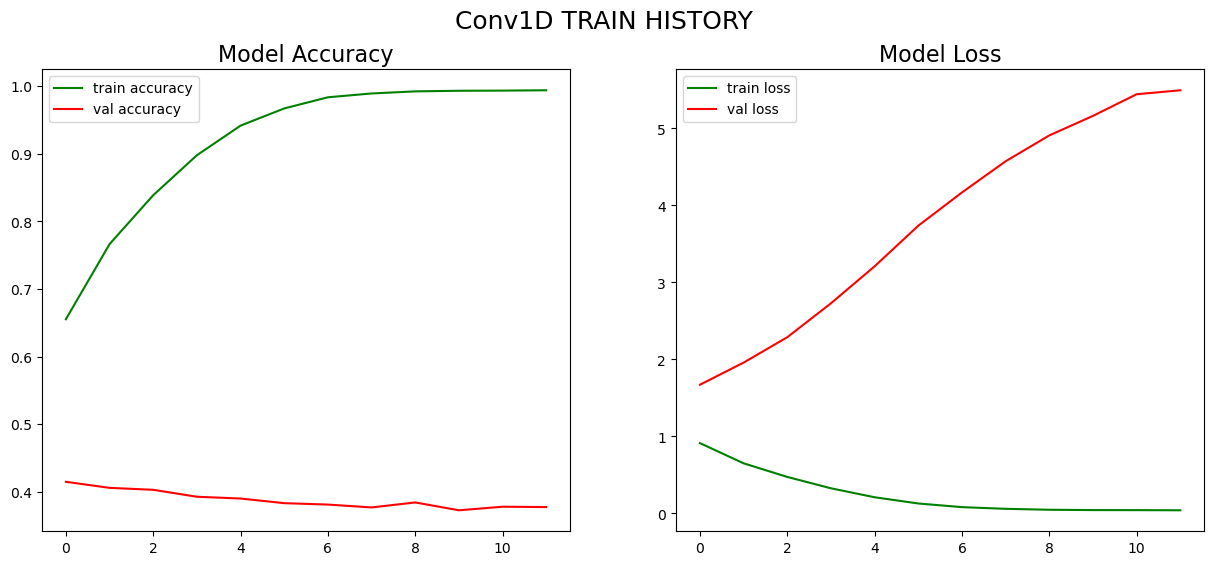

,model,accuracy,precision,recall,f1
0,Conv1D,37.730384,0.378513,0.377304,0.377376


In [38]:
model_4, res4 = run_model(inputs, outputs, "model_4_Conv1D", 12, "Conv1D", "Conv1D TRAIN HISTORY")
res4

Compare models

In [45]:
results = [res,res1, res2, res3, res4]
results = pd.concat(results, ignore_index=True)
results.index = results['model']
results = results.drop(columns=['model'])

results # check data

,accuracy,precision,recall,f1
model,,,,
LSTM,44.260137,0.445515,0.442601,0.442901
GRU,39.836756,0.399095,0.398368,0.398322
B_LSTM,39.336493,0.393053,0.393365,0.392740
B_GRU,40.152712,0.401179,0.401527,0.401074
Conv1D,37.730384,0.378513,0.377304,0.377376


In [46]:
def plot_results(results, ax1, ax2, ax3, ax4):
    """VISUALIZE RESULTS"""
    # color = ['green', 'cyan', 'blue', 'magenta']
    color1 = plt.cm.spring(np.linspace(0, 1, len(results)))
    color2 = plt.cm.viridis(np.linspace(0, 1, len(results)))
    color3 = plt.cm.winter(np.linspace(0, 1, len(results)))
    color4 = plt.cm.cool(np.linspace(0, 1, len(results)))
        
    ax1 = results['accuracy'].plot.bar(ax=ax1, color=color1, legend=False)
    ax1.set_title("Accuracy", fontsize=16)
    
    ax2 = results['precision'].plot.bar(ax=ax2, color=color2, legend=False)
    ax2.set_title("Precision", fontsize=16)   
    
    ax3 = results['recall'].plot.bar(ax=ax3, color=color3, legend=False)
    ax3.set_title("Recall", fontsize=16) 
    
    ax4 = results['f1'].plot.bar(ax=ax4, color=color4, legend=False)
    ax4.set_title("F1", fontsize=16)
    
        
    print()

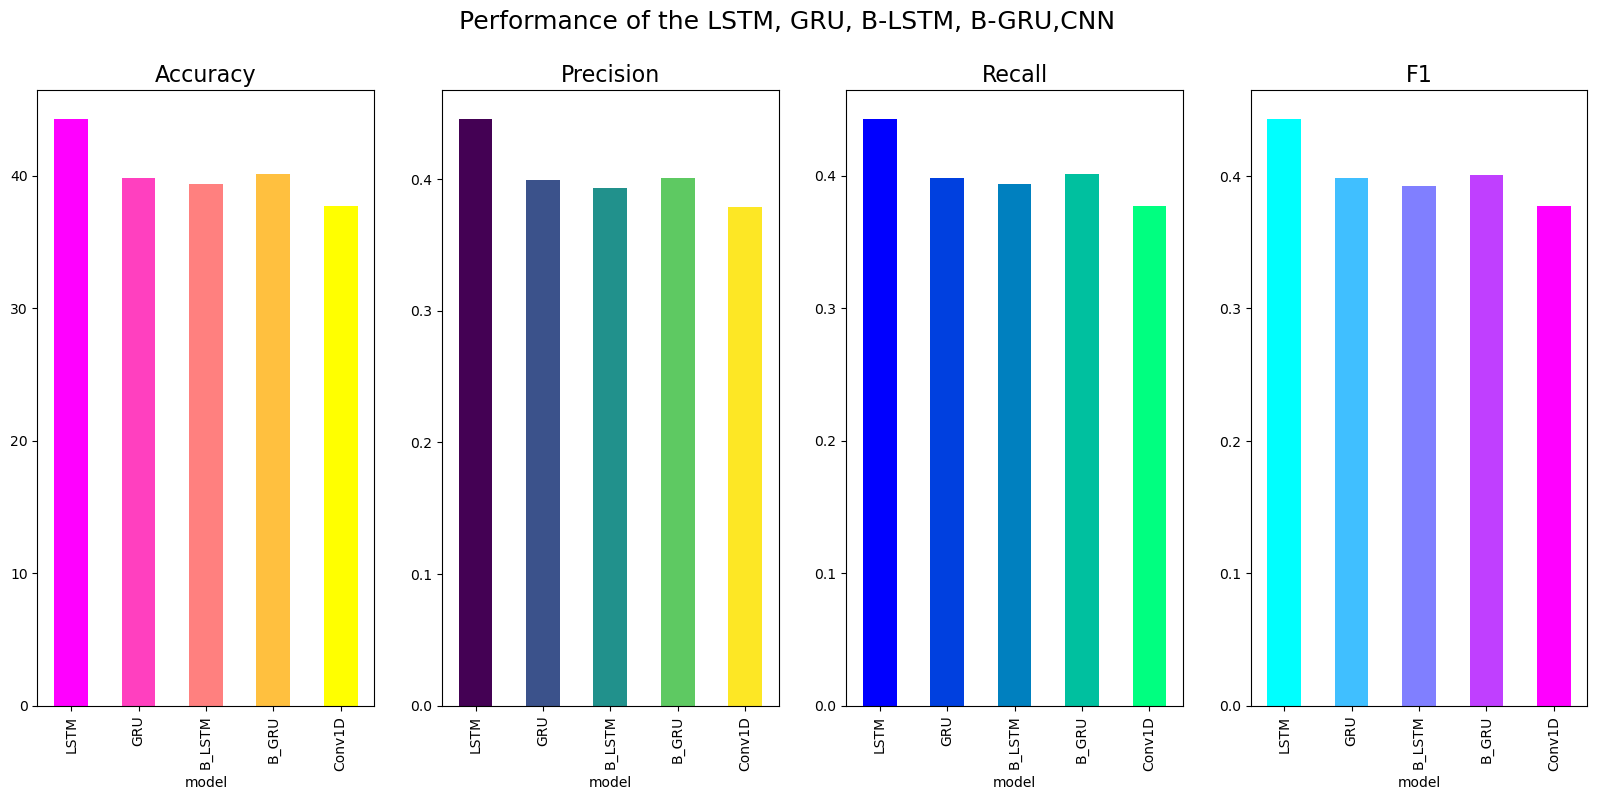

In [47]:
# plot data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
plt.suptitle("Performance of the LSTM, GRU, B-LSTM, B-GRU,CNN", fontsize=18) 
plot_results(results, ax1, ax2, ax3, ax4)
plt.show()